In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle as pkl
import sys
import matplotlib.pyplot as plt
from torchvision import utils
sys.path.append('../..')
from evaluation.scripts.challenge_eval import run_bg_challenge
from pytorch_lightning.callbacks import Callback
from data.bgc_eval_datasets import ImageNet9

class AutopickleModel(Callback): #Thing that was helping with pickling is also messing up pickling, how delightful
    def __init__(self, model):
        self.model = model

    def on_validation_epoch_end(self, trainer, module):
        model_file = open(args.save_path, 'wb')
        # The base model should not need it anymore- and it's a bit messing up pickling
        self.model.base_model.train_dataloader = None
        self.model.base_model.val_dataloader = None
        self.model.base_model.trainer = None
        pkl.dump(self.model, model_file)
        model_file.close()

In [2]:
MODEL_PATHS = ['/home/macron/Praca Magisterska/Gotowe Sieci/clean.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_3ep_start_epclear_nolimit.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_256emb_conv.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_nf.pkl',
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_nf.pkl'
               '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_100emb_conv.pkl',]
               #'/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_100emb.pkl',
               #'/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_77ep_256emb.pkl']
cached = {'clean' : 100 - 99.97530864197531, 'flow_3ep_start_epclear_nolimit' : 0.0,
         'flow_nice_77ep_256emb_conv' : 0.0, 'flow_nice_77ep_nf' : 0.0}
force = False

or_path = '/home/macron/Praca Magisterska/BGC Dane/original/val/'
fg_path = '/home/macron/Praca Magisterska/BGC Dane/fg_mask/val/'

bg_ds = ImageNet9(f'/home/macron/Praca Magisterska/BGC Dane/only_bg_t')
bg_loader = bg_ds.make_loaders(batch_size=16, workers=8)

results = {}
for path in MODEL_PATHS:
    model_name = path.split('/')[-1].replace('.pkl', '')
    if model_name in cached and not force:
        results[model_name] = cached[model_name]
        continue
    model_file = open(path, 'rb')
    model = pkl.load(model_file)
    model_file.close()
    model.cuda()
    avg = (1 - run_bg_challenge(model, bg_loader, or_path, fg_path)) * 100
    
    print(f'Model {model_name}: {avg}')
    results[model_name] = avg

==> Preparing dataset ImageNet9..


 33%|██████████████▋                             | 3/9 [09:39<19:33, 195.65s/it]Traceback (most recent call last):
Traceback (most recent call last):
100%|████████████████████████████████████████████| 9/9 [28:33<00:00, 190.39s/it]


Model flow_nice_77ep_256emb_conv: -99.0


100%|████████████████████████████████████████████| 9/9 [27:17<00:00, 181.89s/it]

Model flow_nice_77ep_nf: -99.0


NotADirectoryError: [Errno 20] Not a directory: '/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_nf.pkl/home/macron/Praca Magisterska/Gotowe Sieci/flow_nice_30ep_100emb_conv.pkl'

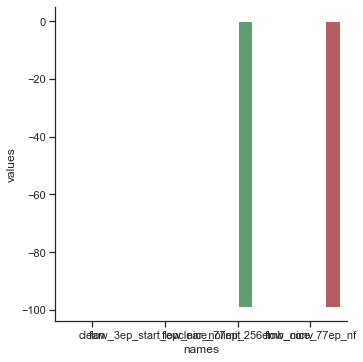

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

names = []
values = []
for md in results:
    names.append(md)
    values.append(results[md])

sns.catplot(x="names", y="values", hue="names", kind="bar", data=pd.DataFrame({'names' : names, 'values' : values}))